/home/ckqsudo/miniconda3/envs/py11/lib/python3.11/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([64, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: grad can be implicitly created only for scalar outputs

Epoch 1/50, Loss: 1.0962
Epoch 2/50, Loss: 1.0158
Epoch 3/50, Loss: 1.0085
Epoch 4/50, Loss: 1.0071
Epoch 5/50, Loss: 1.0072
Epoch 6/50, Loss: 1.0069
Epoch 7/50, Loss: 1.0062
Epoch 8/50, Loss: 1.0064
Epoch 9/50, Loss: 1.0071
Epoch 10/50, Loss: 1.0066
Epoch 11/50, Loss: 1.0064
Epoch 12/50, Loss: 1.0066
Epoch 13/50, Loss: 1.0072
Epoch 14/50, Loss: 1.0063
Epoch 15/50, Loss: 1.0065
Epoch 16/50, Loss: 1.0055
Epoch 17/50, Loss: 1.0061
Epoch 18/50, Loss: 1.0064
Epoch 19/50, Loss: 1.0059
Epoch 20/50, Loss: 1.0059
Epoch 21/50, Loss: 1.0068
Epoch 22/50, Loss: 1.0058
Epoch 23/50, Loss: 1.0063
Epoch 24/50, Loss: 1.0052
Epoch 25/50, Loss: 1.0057
Epoch 26/50, Loss: 1.0062
Epoch 27/50, Loss: 1.0053
Epoch 28/50, Loss: 1.0046
Epoch 29/50, Loss: 1.0038
Epoch 30/50, Loss: 1.0033
Epoch 31/50, Loss: 1.0019
Epoch 32/50, Loss: 1.0024
Epoch 33/50, Loss: 1.0016
Epoch 34/50, Loss: 1.0007
Epoch 35/50, Loss: 0.9994
Epoch 36/50, Loss: 0.9993
Epoch 37/50, Loss: 0.9984
Epoch 38/50, Loss: 0.9976
Epoch 39/50, Loss: 0.

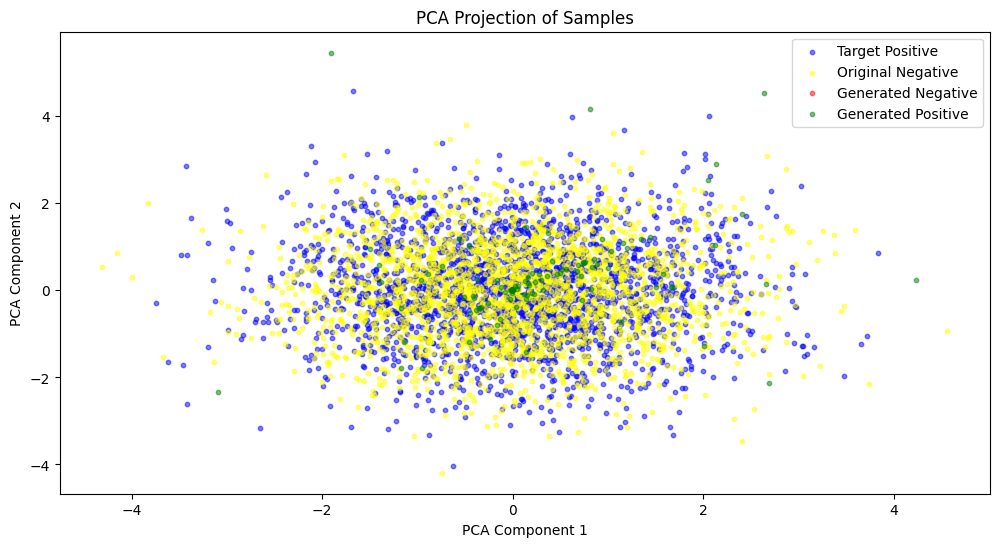

/home/ckqsudo/miniconda3/envs/py11/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


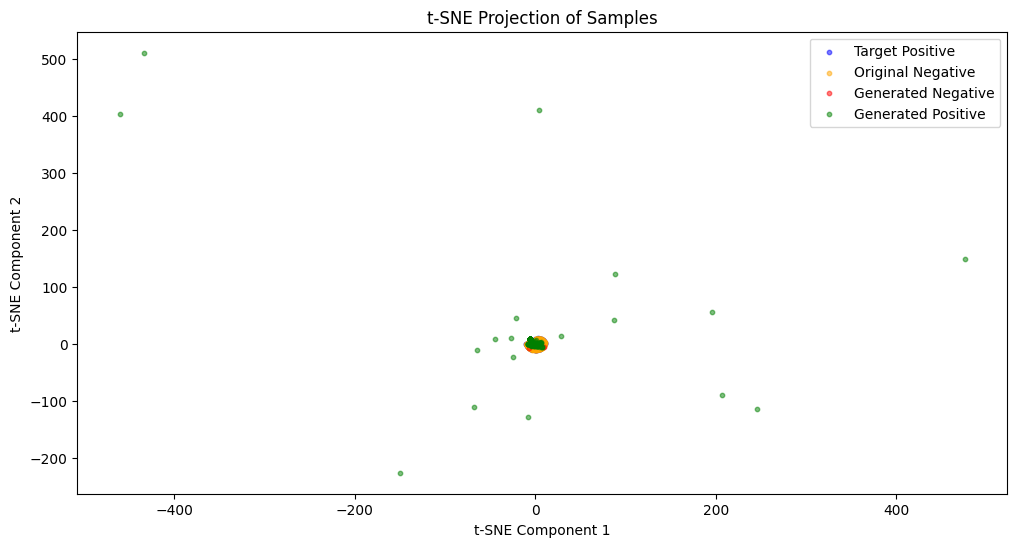

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# 假设数据已加载为以下变量
# data: Tensor of shape (4560, 128)
# labels: Tensor of shape (4560,) with values 0 or 1

class VectorDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data.float()
        self.labels = labels.float()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

class MLP(nn.Module):
    def __init__(self, input_size=128, hidden_size=256, output_size=128):
        super(MLP, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
            # 如果需要，可以添加激活函数，如nn.Sigmoid()等
        )

    def forward(self, x):
        encoded = self.encoder(x)
        reconstructed = self.decoder(encoded)
        return reconstructed

class CustomLoss(nn.Module):
    def __init__(self, positive_mean, alpha=1.0):
        super(CustomLoss, self).__init__()
        self.mse = nn.MSELoss()
        self.positive_mean = positive_mean
        self.alpha = alpha  # 权重因子，可以根据需要调整

    def forward(self, outputs, targets, labels):
        # 对于标签为1的样本，使用MSE损失
        loss_positive = self.mse(outputs[labels == 1], targets[labels == 1])

        # 对于标签为0的样本，使用与正样本均值的距离作为损失
        if (labels == 0).sum() > 0:
            loss_negative = torch.mean(torch.norm(outputs[labels == 0] - self.positive_mean, dim=1))
        else:
            loss_negative = torch.tensor(0.0).to(outputs.device)

        # 总损失为正样本损失和负样本损失的加权和
        loss = loss_positive + self.alpha * loss_negative
        return loss

def train_model(data, labels, epochs=50, batch_size=64, learning_rate=1e-3, alpha=1.0):
    dataset = VectorDataset(data, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = MLP()
    model = model.to(data.device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # 计算正样本的均值，用于负样本的损失计算
    positive_data = data[labels == 1]
    if len(positive_data) == 0:
        raise ValueError("没有正样本（标签为1）的数据。")
    positive_mean = positive_data.mean(dim=0)
    positive_mean = positive_mean.to(data.device)

    criterion = CustomLoss(positive_mean, alpha=alpha)

    model.train()
    for epoch in range(epochs):
        epoch_loss = 0.0
        for batch_data, batch_labels in dataloader:
            batch_data = batch_data.to(data.device)
            batch_labels = batch_labels.to(data.device)

            optimizer.zero_grad()
            outputs = model(batch_data)
            loss = criterion(outputs, batch_data, batch_labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * batch_data.size(0)

        epoch_loss /= len(dataset)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}')

    return model

# 统计量打印函数
def print_statistics(tensor, name):
    mean = torch.mean(tensor, dim=0).cpu().numpy()
    std = torch.std(tensor, dim=0).cpu().numpy()
    print(f'{name} - Mean: {mean[:5]}... , Std: {std[:5]}...')

# 可视化函数：PCA
def visualize_distributions_PCA(target_positive, origin_neg, generated_neg, generated_pos):
    """
    使用PCA将高维数据降维到2维，并绘制分布图。
    """
    pca = PCA(n_components=2)
    # 结合所有数据进行PCA
    combined = np.vstack((target_positive, origin_neg, generated_neg, generated_pos))
    pca.fit(combined)

    target_positive_pca = pca.transform(target_positive)
    origin_neg_pca = pca.transform(origin_neg)
    generated_neg_pca = pca.transform(generated_neg)
    generated_pos_pca = pca.transform(generated_pos)

    plt.figure(figsize=(12, 6))

    # 绘制正样本
    plt.scatter(target_positive_pca[:, 0], target_positive_pca[:, 1], 
                c='blue', label='Target Positive', alpha=0.5, s=10)

    # 绘制原始负样本
    plt.scatter(origin_neg_pca[:, 0], origin_neg_pca[:, 1],
                c='yellow', label='Original Negative', alpha=0.5, s=10)

    # 绘制生成的负样本
    plt.scatter(generated_neg_pca[:, 0], generated_neg_pca[:, 1], 
                c='red', label='Generated Negative', alpha=0.5, s=10)

    # 绘制生成的正样本
    plt.scatter(generated_pos_pca[:, 0], generated_pos_pca[:, 1], 
                c='green', label='Generated Positive', alpha=0.5, s=10)

    plt.legend()
    plt.title('PCA Projection of Samples')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()

# 可视化函数：t-SNE
def visualize_distributions_tsne(target_positive, origin_neg, generated_neg, generated_pos):
    """
    使用t-SNE将高维数据降维到2维，并绘制分布图。
    """
    tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
    # 结合所有数据进行t-SNE
    combined = np.vstack((target_positive, origin_neg, generated_neg, generated_pos))
    tsne_results = tsne.fit_transform(combined)

    # 划分降维后的数据
    n_positive = target_positive.shape[0]
    n_origin_neg = origin_neg.shape[0]
    n_generated_neg = generated_neg.shape[0]
    # n_generated_pos = generated_pos.shape[0]

    target_positive_tsne = tsne_results[:n_positive]
    origin_neg_tsne = tsne_results[n_positive:n_positive + n_origin_neg]
    generated_neg_tsne = tsne_results[n_positive + n_origin_neg:n_positive + n_origin_neg + n_generated_neg]
    generated_pos_tsne = tsne_results[n_positive + n_origin_neg + n_generated_neg:]

    plt.figure(figsize=(12, 6))

    # 绘制正样本
    plt.scatter(target_positive_tsne[:, 0], target_positive_tsne[:, 1], 
                c='blue', label='Target Positive', alpha=0.5, s=10)
    # 绘制原始负样本
    plt.scatter(origin_neg_tsne[:, 0], origin_neg_tsne[:, 1],
                c='orange', label='Original Negative', alpha=0.5, s=10)
    
    # 绘制生成的负样本
    plt.scatter(generated_neg_tsne[:, 0], generated_neg_tsne[:, 1], 
                c='red', label='Generated Negative', alpha=0.5, s=10)
    
    # 绘制生成的正样本
    plt.scatter(generated_pos_tsne[:, 0], generated_pos_tsne[:, 1], 
                c='green', label='Generated Positive', alpha=0.5, s=10)

    plt.legend()
    plt.title('t-SNE Projection of Samples')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.show()

def main():
    # 示例用法
    # 请根据实际情况加载您的数据
    # 这里使用随机数据作为示例
    torch.manual_seed(42)
    np.random.seed(42)
    data_tensor = torch.randn(4560, 128)
    labels_tensor = torch.randint(0, 2, (4560,))

    # 将数据移动到GPU（如果可用）
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    data_tensor = data_tensor.to(device)
    labels_tensor = labels_tensor.to(device)

    # 训练模型
    model = train_model(data_tensor, labels_tensor, epochs=50, batch_size=64, learning_rate=1e-3, alpha=1.0)
    model.to(device)

    # 先不保存模型
    # torch.save(model.state_dict(), 'mlp_reconstruction.pth')

    # 生成重建样本
    model.eval()
    with torch.no_grad():
        all_outputs = model(data_tensor)

    # 分离生成的正负样本
    generated_pos = all_outputs[labels_tensor == 1]
    generated_neg = all_outputs[labels_tensor == 0]

    # 获取原始正负样本
    all_positive = data_tensor[labels_tensor == 1]
    all_negative = data_tensor[labels_tensor == 0]

    # 打印统计量
    print("\nStatistics of Generated Negative Samples:")
    print_statistics(generated_neg, "Generated Negative")

    print("\nStatistics of Generated Positive Samples:")
    print_statistics(generated_pos, "Generated Positive")

    print("\nStatistics of Target Positive Samples:")
    print_statistics(all_positive, "Target Positive")

    # 转换为numpy数组用于可视化
    all_positive_np = all_positive.cpu().numpy()
    all_negative_np = all_negative.cpu().numpy()
    generated_neg_np = generated_neg.cpu().numpy()
    generated_pos_np = generated_pos.cpu().numpy()

    # 可视化样本分布（使用PCA）
    visualize_distributions_PCA(all_positive_np, all_negative_np, generated_neg_np, generated_pos_np)

    # 可视化样本分布（使用t-SNE）
    visualize_distributions_tsne(all_positive_np, all_negative_np, generated_neg_np, generated_pos_np)

if __name__ == "__main__":
    main()
